In [2]:
%pylab inline

import numpy as np
import cv2
from scipy.signal import convolve2d

Populating the interactive namespace from numpy and matplotlib


## Setup, constants, etc.

In [5]:
vid = '../videos/smallbees.mov'
#vid = '../videos/bees30sec.mov'
max_frames = 40
averaging_window = 30
color_diff_threshold = 10
diff_spacing = 20

## Load video

In [6]:
cap = cv2.VideoCapture(vid)

frames = []
for i in range(max_frames):
    if i % 10 == 0:
        print(i)
    ret, frame = cap.read()
    convert = cv2.cvtColor(frame, cv2. COLOR_BGR2RGB).astype('float32')
    frames.append(convert)
    
frames = np.array(frames)
frames.shape, frames.dtype

0
10
20
30


((40, 360, 640, 3), dtype('float32'))

Text(0.5, 1.0, 'Frame 20')

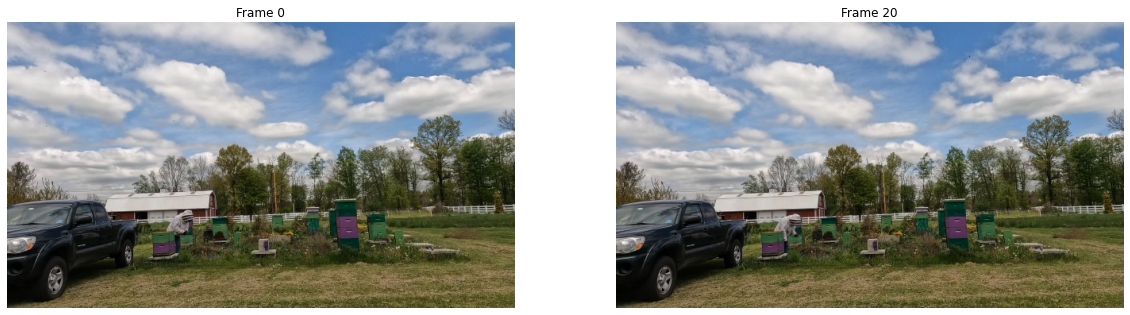

In [7]:
frame0 = frames[0].astype(dtype=np.uint8)
frame20 = frames[20].astype(dtype=np.uint8)

fig = figure(figsize=(20,20))
fig.add_subplot(1,2,1)
imshow(frame0)
axis('off')
title('Frame 0')

fig.add_subplot(1,2,2)
imshow(frame20)
axis('off')
title('Frame 20')

## Diff nth frame with average of nearby frames

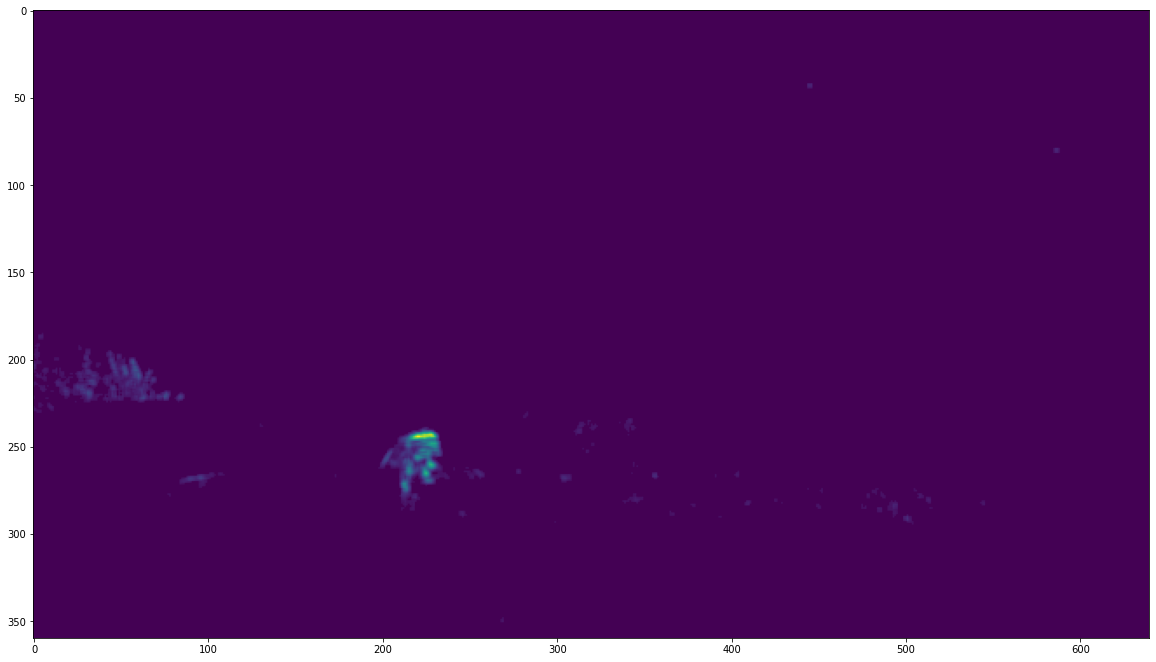

In [8]:
def convolve_all_colours(im):
    """
    Convolves im with window, over all three colour channels
    https://www.degeneratestate.org/posts/2016/Oct/23/image-processing-with-numpy/
    """
    window = np.ones((3,3))
    window /= np.sum(window)
    
    ims = []
    for d in range(3):
        im_conv_d = convolve2d(im[:,:,d], window, mode="same", boundary="symm")
        ims.append(im_conv_d)

    im_conv = np.stack(ims, axis=2).astype("float32")
    
    return im_conv

def nth_frame_diff(n):
    # load window of frames
    a = max(0, int(n - averaging_window/2))
    b = int(n + averaging_window/2)
    window = frames[a:b]
    
    # average all frames in window together
    medianFrame = np.median(window, axis=0)
    
    # get abs value of diff of each color channel between
    # frame of interest and median frame
    diff3 = abs(medianFrame - frames[n])
    
    # smooth diff image (still 3 rgb channels)
    diff3 = convolve_all_colours(diff3)
    
    # get variation at a single pixel: sqrt(r*r + g*g + b*b)
    dif = np.sqrt(np.sum(diff3**2, axis=2))
    
    # threshold (~10 is a good value)
    dif = (dif > color_diff_threshold) * dif
    
    return dif
    
figure(figsize=(20,20))
imshow(nth_frame_diff(20))

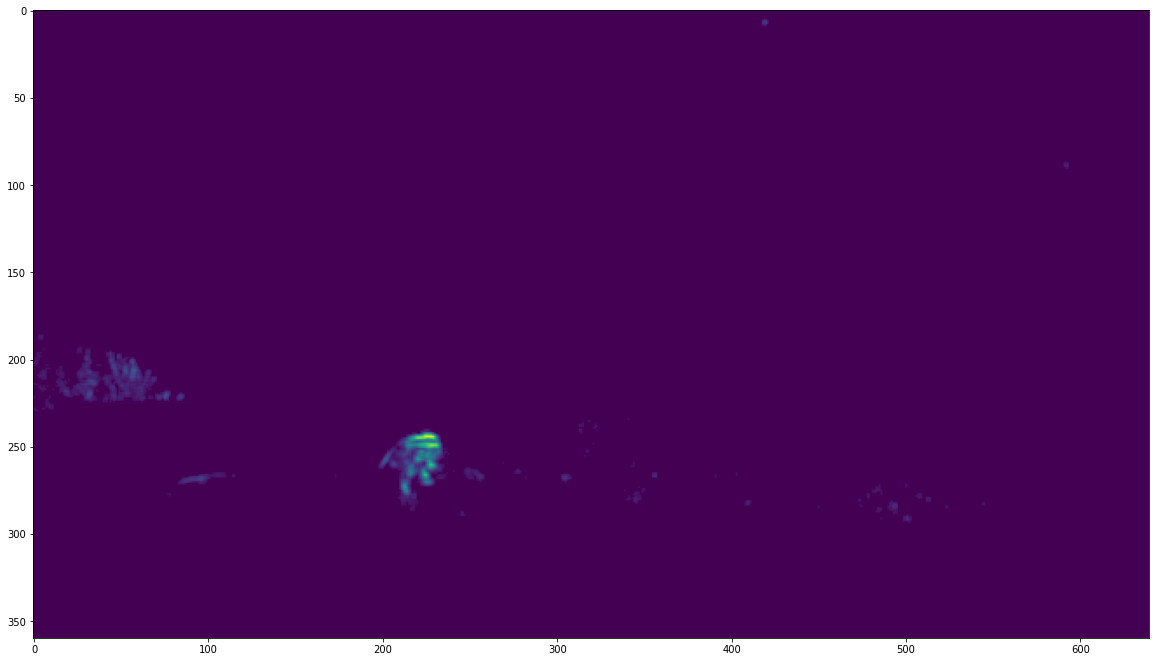

In [9]:
figure(figsize=(20,20))
imshow(nth_frame_diff(21))

## Find local maxima (bees?!)

In [10]:
# from http://sonic.net/~goddard/home/bees/bees.html tracks.py
# this code is very slow on bigger images

def maximum_positions(a, threshold, spacing = 0):

    m = (a[:,:] >= threshold)
    np.logical_and(m[:-1,:], a[:-1,:] > a[1:,:], m[:-1,:])
    np.logical_and(m[1:,:], a[1:,:] > a[:-1,:], m[1:,:])
    np.logical_and(m[:,:-1], a[:,:-1] > a[:,1:], m[:,:-1])
    np.logical_and(m[:,1:], a[:,1:] > a[:,:-1], m[:,1:])
    y,x = m.nonzero()
    points = np.array((x,y)).transpose()
    p = remove_nearby_points(points, spacing, a)
    return p

# -----------------------------------------------------------------------------
#
def remove_nearby_points(points, dmin, a):

    if dmin <= 0:
        return points
    remove = set()
    ap = a[points[:,1],points[:,0]]
    s = ap.argsort()
    n = len(points)
    for i in range(n):
        if not s[i] in remove:
            for j in range(i+1,n):
                if not s[j] in remove:
                    step = points[s[j]]-points[s[i]]
                    if (step*step).sum() < dmin*dmin:
                        remove.add(s[j])
    p = np.array(tuple(points[i] for i in range(n) if not i in remove), np.int32)
    return p

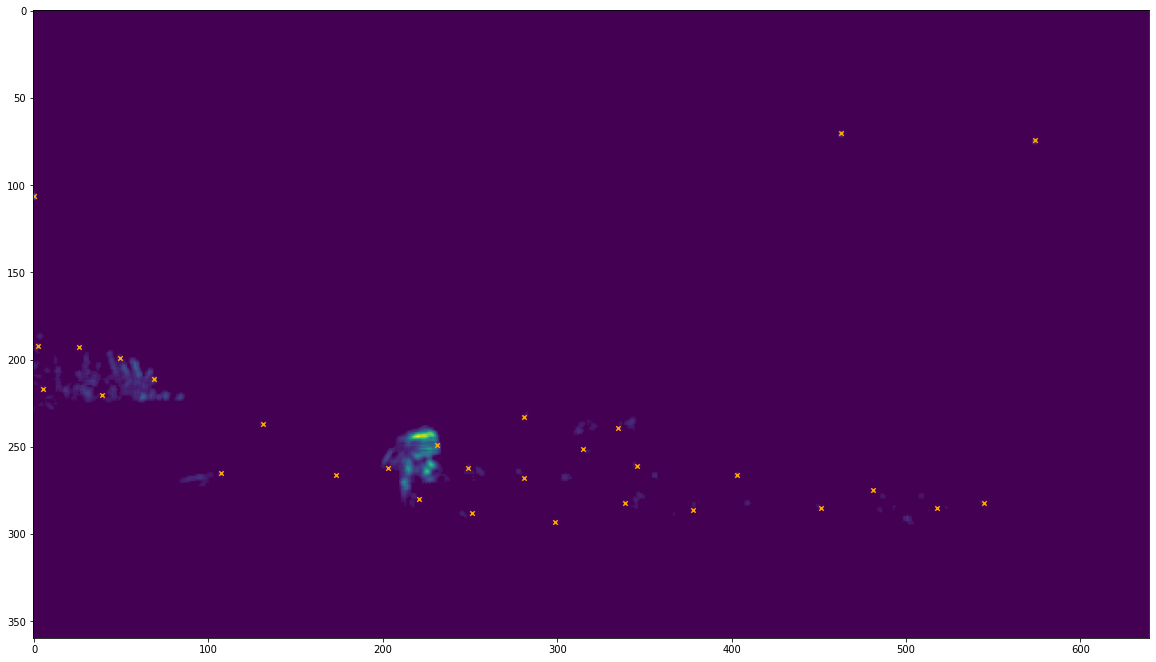

In [14]:
d = nth_frame_diff(19)
points = maximum_positions(d, color_diff_threshold, diff_spacing)

plt.figure(figsize=(20,20))
plt.imshow(d)
plt.scatter(points[:,0], points[:,1], marker="x", c="orange", s=20)

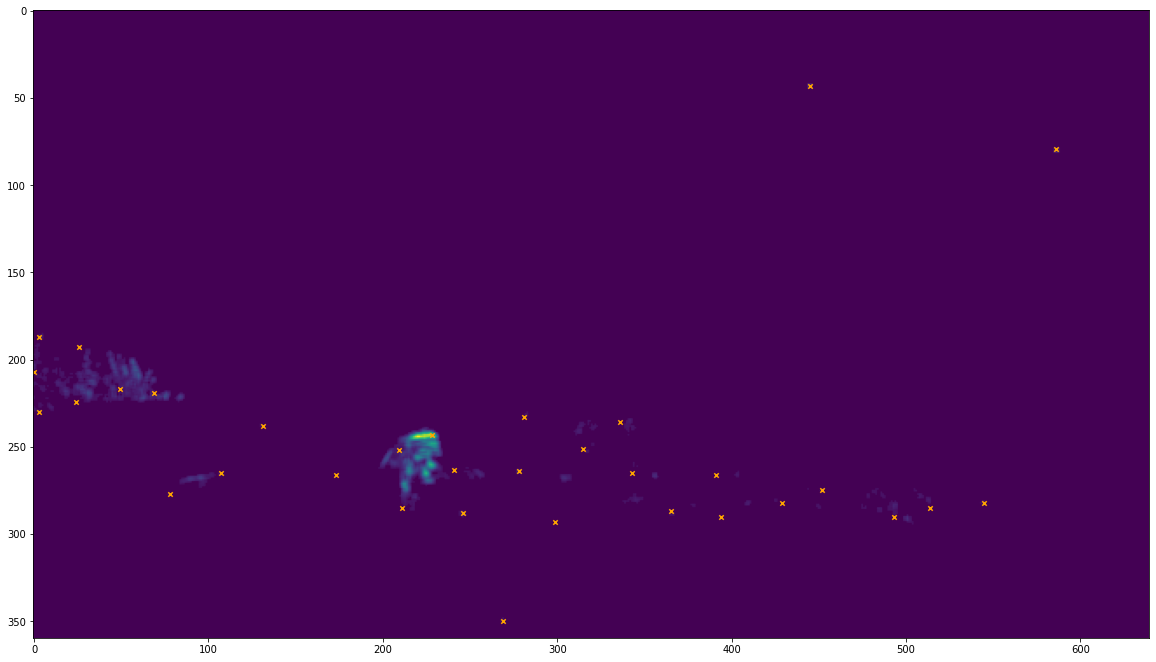

In [15]:
d = nth_frame_diff(20)
points = maximum_positions(d, color_diff_threshold, diff_spacing)

plt.figure(figsize=(20,20))
plt.imshow(d)
plt.scatter(points[:,0], points[:,1], marker="x", c="orange", s=20)

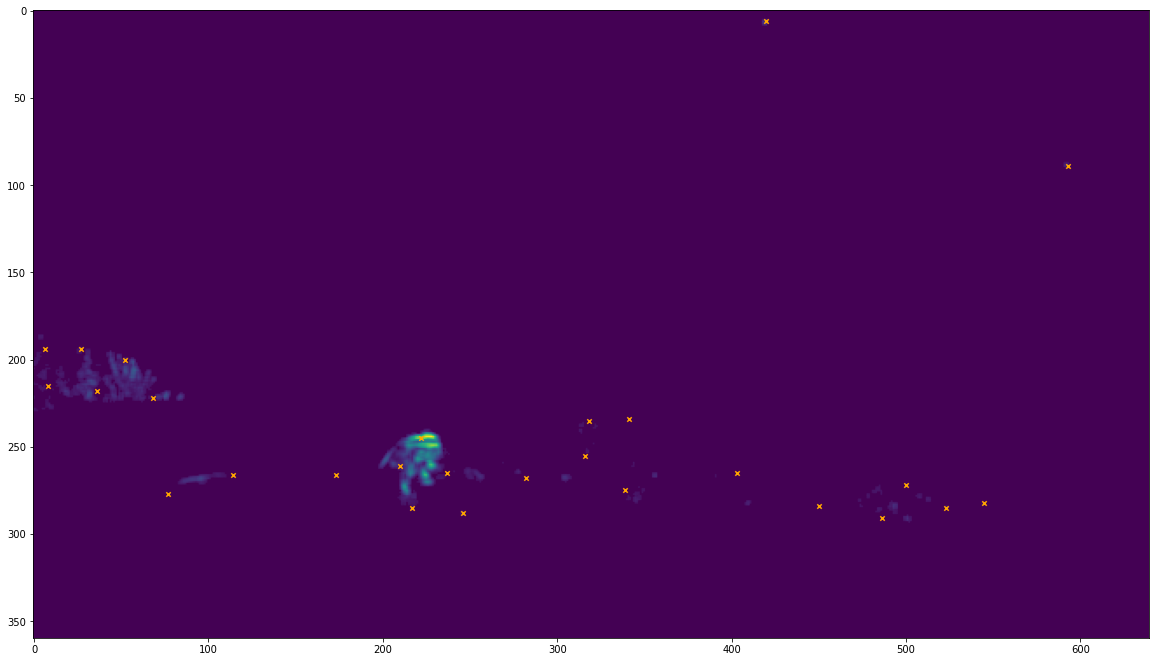

In [16]:
d = nth_frame_diff(21)
points = maximum_positions(d, color_diff_threshold, diff_spacing)

plt.figure(figsize=(20,20))
plt.imshow(d)
plt.scatter(points[:,0], points[:,1], marker="x", c="orange", s=20)